# Intruduction
__Problem__ : โรงพยาบาลรักษาโรคมะเร็งต้องการให้เราตัดสินว่าผู้ป่วยเป็นมะเร็งชนิดร้ายแรง หรือก้อนเนื้องอกที่ไม่อันตราย. เพื่อที่จะช่วยแบ่งประเภทของผู้ป่วยแต่ละคน ทางโรงพยาบาลได้ให้ข้อมูลอายุของคนไข้และขนาดของเนื้องอก. โดยการคาดเดา เราสามารถเดาได้ว่าผู้ป่วยที่มีอายุน้อย และ/หรือผู้ป่วยที่มีเนื่้องอกขนาดเล็กมีโอกาสน้อยกว่าที่จะเป็นมะเร็งชนิดร้ายแรง. ในตัวอย่างข้อมูลที่โรงพยาบาลให้มานั้นจุดสีแดงแสดงถึงผู้ป่วยมะเร็งชนิดร้ายแรงและจุดสีน้ำเงินแสดงถึงผู้ป่วยที่เป็นเนื้องอกชนิดที่ไม่อันตราย หมายเหตุ นี่เป็นแค่ตัวอย่างข้อมูลเท่านั้น

In [80]:
from IPython.display import Image
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=500, height=500)

__Goal__ : เป้าหมายของเราคือการศึกษาตัวแบ่ง (Classifier) ที่สามารถบ่งบอกได้ว่าผู้ป่วยเป็นมะเร็งหรือเป็นเนื้องอกที่มีอันตรายได้อย่างอัตโนมัติ โดยพิจารณาจากสองปัจจัยได้แก่ อายุและขนาดเนื้องอก. ในตัวอย่างนี้เราจะสร้าง Linear Classifier ซึ่งเป็นพื้นฐานของ Deep networks.

In [81]:
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=500, height=500)

__Approach__ : ในทุกทุกอัลกอริทึมการเรียนรู็นั้นมักประกอบด้วยห้าขั้นตอน ได้แก่ 
1. __Data reading__: สร้างข้อมูลจำลองโดยประกอบด้วยสองคุณลักษณะ(features) คือ อายุและขนาดก้อนเนื้องอก
2. __Data preprocessing__: บ่อยครั้ง ที่ฟิเจอร์แต่ละอันต้องถูกทำการ scaling ใหม่. โดยปรกติแล้วมักจะทำการสเกลข้อมูลให้อยู่ระหว่าง  0 ถึง 1. แต่เพื่อให้ทุกอย่างออกมาง่าย เราจะไม่ทำการสเกลในตัวอย่างนี้
3. __Model Creation__: แนะนำ linear model แบบพื้นฐาน
4. __Learning Model__: ขั้นตอนนี้รู้จักกันในชื่อ training. การหา linear model ที่เหมาะสมสามารถทำได้หลายวิธี ใน CNTK เราใช้ Stochastic Gradient Descent a.k.a. SGD.
5. __Evaluation__: ขั้นตอนนี้รู็จักกันในชื่อ testing. โดยจะทำการประเมินโมเดลโดยใช้ข้อมูลที่ไม่เคยใช้ตอน training 

# Logistic Regression

เป็นเทคนิคการเรียนรู้ด้วยเครื่องแบบพื้นฐานที่ใช้ linear weighted combination of features and generates the probability of predicting different classes. ในกรณีของเรา ตัวแบ่งจะให้ค่าออกมาเป็นความน่าจะเป็น [0, 1] แล้วจึงนำไปเปรียบเทียบกับค่า threshold (เช่น 0.5) เพื่อสร้างเป็น ลาเบลไบนารี่ (0 หรือ 1) 

In [82]:
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

จากรูปด้านบน ผลที่ได้จากแต่ละอินพุตจะถูก linearly weighted และรวบรวม. ค่าผลรวมทั้งหมดที่ได้จะถูกแมพให้อยู่ในช่วง 0 ถึง 1 โดยใช้ sigmoid function. สำหรับการแบ่งประเภทที่มีเอ้าพุตเลเบลมากกว่าสองสามารถใช้ softmax function ได้

In [83]:
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C

C.cntk_py.set_fixed_random_seed(1)

# 1. Data Generation

ในส่วนนี้เราจะทำการสังเคราะห์ข้อมูลที่ลอกเลียนแบบการเกิดโดคมะเร็งโดยใช้ numpy library. 
เราต้องการสองคุณลักษณะ(feature) และสองเอ้าพุตคลาส(มะเร็ง/แดง หรือ เนื้องอก/ฟ้า)

In [84]:
# Define the network
input_dim = 2
num_output_classes = 2

## Input and Labels

ในตัวอย่างนี้เราจะสังเคราะห์ข้อมูลโดยใช้ numpy library สำหรับปัญหาจริงนั้นอาจจะใช้ __[reader](https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93)__ ที่จะทำการอ่านค่าคุณลักษณะจากข้อมูลคนไข้แต่ละคน. สำหรับตัวอย่างนี้ ตัวแปรอายุที่จำลองได้จะถูกสเกลลงมาให้คล้ายกับตัวแปรอื่นๆ. นี่คือหัวใจสำคัญของการทำ data preprecessing ที่เราจะได้เรียนกันในตัวอย่างต่อๆ ไป 

In [85]:
# Ensure that we always get the same results
np.random.seed(1)

def gen_random_data_sample(sample_size, feature_dimension, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)
    
    # make sure that data is separable
    X = (np.random.randn(sample_size, feature_dimension) + 3) * (Y + 1)
    
    # change datatype to match the input that used later in this tutorial
    # default type is double
    X = X.astype(np.float32)
    
    # convert class 0 into the vector "1 0 0", 
    # class 1 into the vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    
    return X, Y

features, labels = gen_random_data_sample(32, input_dim, num_output_classes)
#print()
#print(features[:,1])
#print()
#print(labels[:,0])

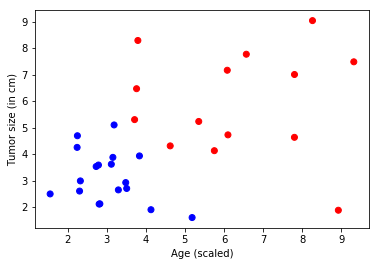

In [86]:
# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# let 0 represent malignant/red and 1 represent benign/blue 
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

# Model Creation

Logistic regression(LR) network เป็นโมเดลเชิงเส้นแบบง่ายที่รับอินพุตแบบเวกเตอร์ของตัวเลขที่อธิบายถึงคุณสมบัติของส่ิ่งที่ต้องการแยกประเภท(บางทีก็เรียกกันว่า ฟิเจอร์เวกเตอร์ __x__ โหนดสีฟ้าจากรูปด้านล่าง) แล้วแสดงผลเป็นส่ิงที่เรียกว่า evidence(z) (ผลลัพธ์จากโหนดสีเขียว หรือที่เรียกว่า "activation"). แต่ละฟิเจอร์ในอินพุตเลเยอร์เชื่อมกับเอ้าพุตโหนดโดยเส้นเชื่อมที่มีค่า weight (w) ที่มีค่าต่างๆกันโดยขนาดความหนาของเส้น

In [87]:
# Figure 4
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

The first step is to compute the evidence for an observation. 

$$z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w} \cdot \textbf{x} + b$$ 

where $\bf{w}$ is the weight vector of length $n$ and $b$ is known as the [bias][] term. Note: we use **bold** notation to denote vectors. 

The computed evidence is mapped to a (0, 1) range using a `sigmoid` (when the outcome can be in one of two possible classes) or a `softmax` function (when the outcome can be in one of more than two possible classes).



For example, if each data point was a grayscale image of height 10 pixels and width 5 pixels, 
the input feature would be a vector of 50 floating-point values representing the intensity of each of the 50 pixels, 
and could be written as C.input_variable(10*5, np.float32). 

Similarly, in our example the dimensions are age and tumor size, thus input_dim = 2.

In [88]:
feature = C.input_variable(input_dim, np.float32)
print(type(feature))
print(feature)

<class 'cntk.variables.Variable'>
Input('Input250', [#], [2])


# Network setup

Linear_layer ฟังก์ชั่นค่อนข้างคอมพลิเม้นต์ได้อย่างตรงไปตรงมาจากสมการด้านบน. เราจะทำการดำเนินการสองขั้นตอน
1. คูณ weight (w) ด้วย features (x) โดยใช้ตัวดำเนินการ CNTK times
2. บวกผลลัพธ์ที่ได้ด้วยค่า bias (b)

In [89]:
# dictionary to store model parameters
mydict = {}

def linear_layer(input_var, output_dimension):
    
    input_dimension = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dimension, output_dimension))
    bias_param = C.parameter(shape=(output_dimension))
    
    mydict['w'], mydict['b'] = weight_param, bias_param
    
    return C.times(input_var, weight_param) + bias_param

ตัวแปร z จะถูกใช้เป็นตัวแทนของเอ้าพุตจากเน็ตเวิร์ค

In [90]:
output_dimension = num_output_classes
z = linear_layer(feature, output_dimension)

## Learning Parameters

ตอนนี้ network เราพร้อมแล้วสิ่งที่ต้องทำต่อไปคือเรียนรู้พารามิเตอร์ __w__ และ __b__ สำหรับเน็ตเวิร์คของเรา. เพื่อที่จะให้บรรลุเป้าหมายเราจำทำการแปลงค่า evidence (z) ที่คำนวนได้ไปเป็นค่าความน่าจะเป็น __p__ โดยใช้ softmax function 

ข้อมูลเพิ่มเติมเกี่ยวกับ __[softmax function](https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax)__ 
activation function อื่นๆ __[จิ้ม](https://docs.microsoft.com/en-us/cognitive-toolkit/Brainscript-Activation-Functions)__


# Training

ผลลัพธ์ที่ได้จาก softmax function คือค่าความน่าจะเป็นที่จะบ่งบอกว่าผลลัพธ์เป็นของคลาสไหน. สำหรับการเทรนตัวแบ่งเราต้องตัดสินใจว่าพฤติกรรมใดที่โมเดลควรจะลอกเลียนแบบ. กล่าวอีกนัยหนึ่งคือ เราต้องการให้ความน่าจะเป็นที่ออกมาใกล้เคียงกับความเป็นจริงมากที่สุด(as close as possible to the observed labels). เราสามารถทำได้โดยการลดความแตกต่าระหว่างผลลัพธ์และ ground-truth labels ให้มากที่สุด. ค่าความต่างคำนวนได้โดย _cost_ หรือ _loss_ function

Cross-entropy เป็น loss ฟังก์ชั่นที่ได้รับความนิยม

$$ H(p) = - \sum_{j=1}^{| \textbf y |} y_j \log (p_j) $$  

where $p$ is our predicted probability from `softmax` function and $y$ is the ground-truth label, provided with the training data. In the two-class example, the `label` variable has two dimensions (equal to the `num_output_classes` or $| \textbf y |$). Generally speaking, the label variable will have $| \textbf y |$ elements with 0 everywhere except at the index of the true class of the data point, where it will be 1.  Understanding the [details][] of the cross-entropy function is highly recommended.

In [91]:
label = C.input_variable(num_output_classes, np.float32)
loss = C.cross_entropy_with_softmax(z, label)

__Evaluation__
In order to evaluate the classification, we can compute the classification_error, which is 0 if our model was correct (it assigned the true label the most probability), otherwise 1.

In [92]:
eval_error = C.classification_error(z, label)

## Configure training

ในแบบฝึกหัดนี้เราใช้ Stochastic Gradient Descent (sgd) เพื่อลด loss function วิธีการนี้เริ่มด้วยการสุ่มค่าพารามิเตอร์เริ่มต้นให้กับโมเดล(weight และ bias ในกรณีของเรา). สำหรับการสังเกตุการแต่ละครั้ง sgd optimizer สามารถคำนวนค่า loss และค่า error ระหว่างเลเบลที่ทำนายได้กับ ground-truth เลเบลและทำการปรับค่า gradient descent เพิ่อสร้างค่าพารามิเตอร์ุชุดใหม่ในการทำงานแต่ละครั้ง

กระบวนการอัพเดทค่าพารามิเตอร์แบบยกเซ็ตหลังจากผ่านไปหนึ่งชุดข้อมูลดังกล่าวค่อนข้างน่าสนใจเนื่องจากกระบวนการปรับค่าพารามิเตอร์ไม่จำเป็นต้องรอให้ข้อมูลทั้งหมด(all observation) ถูกโหลดเข้ามาในหน่วยความจำหรือรอให้คำนวนข้อมูลทั้งหมดก่อน ทำให้เราสามารถเทรนข้อมูลที่มีขนาดใหญ่ได้ อย่างไรก็ตามการปรับค่าพารามิเตอร์โดยอาศัยค่าที่ได้จากการสังเกตุข้อมูลหน่วยเดียวในแต่ละครั้งอาจทำให้ค่าพารามิเตอร์ทีได้เปลี่ยนแปลงมากในแต่ละครั้ง ดังนั้นวิธีที่ดีที่สุดคือค่อยๆ โหลดกลุ่มข้อมูลขนาดเล็ก( small set of observations) แล้วป้อนเข้าตัวโมเดลแล้วใช้ค่าเฉลี่ยของค่า loss หรือ error ไปทำการอัพเดทพารามิเตอร์ในโมเดล. กลุ่มข้อมูลที่ว่ามานี้เรียนว่า "minibatch"

ด้วยการแบ่งข้อมูลออกเป็น minibatch เราจึงมักเก็บตัวอย่างข้อมูลจาก training dataset ขนาดใหญ่. เราทำซ้ำกระบวนการดังกล่าวไปเรื่อยๆ เพื่ออัพเดทค่าโมเดลพารามิเตอร์โดยใช้การรวมกันของ traingin sample ที่แตกต่างกันไปและในขณะเดียวกันก็ค่อยๆลดค่า loss และ  error ไปเรื่อยๆ. เมื่อค่า error ไม่มีการเปลี่ยนแปลงอย่างมีนัยสำคัญแล้วหรือ minibatch ที่ใช้เทรนหมดแล้ว เราจึงเรียกโมเดลนี้ว่าเป็นโมเดลที่ผ่านการเทรนแล้ว

หน่ึงในกุญแจสำคัญของการปรับค่าพารามิเตอร์คือ learning_rate. สำหรับตอนนี้เราสามารถคิดได้ว่ามันคือ scaling factor that modulates how much we change the parameters in any iteration.

In [93]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

First, let us create some helper functions that will be needed to visualize different functions associated with training. Note: these convenience functions are for understanding what goes on under the hood.

In [94]:
# Define a utility function to compute the moving average.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

# utility function that print training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"
    
    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
            
    return mb, training_loss, eval_error

## Run the trainer

มาถึงตอนนี้เราก็พร้อมสำหรับการเทรน Logistic Regression Model ของเรา. เราจึงต้องทำการตัดสินใจว่าข้อมูลใดต้องป้อนให้กับ training engine ของเรา

ในตัวอย่างนี้ แต่ละรอบที่จะทำการปรับค่าจะประกอบด้วยข้อมูล 25 sample (เรียกอีกอย่างว่า minibatch_size) เราต้องการเทรนกับข้อมูลทั้งหมด 20000 ชุด (observations)

In [95]:
minibatch_size = 25
num_samples_to_train = 100000
num_minibatch_to_train = int(num_samples_to_train / minibatch_size)

In [96]:
from collections import defaultdict

# Run the trainer and perform model training
training_progress_output_freq = 100
plotdata = defaultdict(list)

for i in range(0, num_minibatch_to_train):
    features, labels = gen_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Assign the minibatch data to the input variables and train the model on the minibatch
    trainer.train_minibatch({feature: features, label: labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error == "NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.6931, Error: 0.56
Minibatch: 100, Loss: 0.5543, Error: 0.20
Minibatch: 200, Loss: 0.0838, Error: 0.00
Minibatch: 300, Loss: 0.4535, Error: 0.12
Minibatch: 400, Loss: 0.3954, Error: 0.16
Minibatch: 500, Loss: 0.7209, Error: 0.28
Minibatch: 600, Loss: 0.4055, Error: 0.08
Minibatch: 700, Loss: 0.8038, Error: 0.28
Minibatch: 800, Loss: 0.5197, Error: 0.20
Minibatch: 900, Loss: 0.3194, Error: 0.12
Minibatch: 1000, Loss: 0.7393, Error: 0.24
Minibatch: 1100, Loss: 0.3323, Error: 0.08
Minibatch: 1200, Loss: 0.1004, Error: 0.04
Minibatch: 1300, Loss: 0.2032, Error: 0.12
Minibatch: 1400, Loss: 0.1267, Error: 0.08
Minibatch: 1500, Loss: 0.0198, Error: 0.00
Minibatch: 1600, Loss: 0.0459, Error: 0.00
Minibatch: 1700, Loss: 0.8429, Error: 0.28
Minibatch: 1800, Loss: 0.5184, Error: 0.16
Minibatch: 1900, Loss: 0.3989, Error: 0.20
Minibatch: 2000, Loss: 0.2231, Error: 0.16
Minibatch: 2100, Loss: 0.1618, Error: 0.08
Minibatch: 2200, Loss: 0.4003, Error: 0.08
Minibatch: 2300, Loss: 

In [97]:
print(plotdata)

defaultdict(<class 'list'>, {'batchsize': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900], 'loss': [0.693147201538086, 0.5543411636352539, 0.08376224517822266, 0.45352127075195314, 0.39540409088134765, 0.720854263305664, 0.40550594329833983, 0.8038418579101563, 0.5196939849853516, 0.3193937873840332, 0.7392544555664062, 0.3322684860229492, 0.10042991638183593, 0.20321998596191407, 0.1266623878479004, 0.0198435115814209, 0.045924296379089354, 0.8429467010498047, 0.5183749771118165, 0.3988755035400391, 0.22308834075927733, 0.16179410934448243, 0.400335693359375, 0.07646282196044922, 0.06823227405548096, 0.33156627655029297, 0.11248283386230469, 0.1347654342651367, 0.6830796051025391, 0.17992404937744141, 0.18005096435546875, 0.3948356246948242, 0.1852935028076172, 0.2638503456115723, 0.5055094146728516, 0.2127

In [98]:
print(plotdata["batchsize"])

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900]


In [99]:
print(plotdata["loss"])

[0.693147201538086, 0.5543411636352539, 0.08376224517822266, 0.45352127075195314, 0.39540409088134765, 0.720854263305664, 0.40550594329833983, 0.8038418579101563, 0.5196939849853516, 0.3193937873840332, 0.7392544555664062, 0.3322684860229492, 0.10042991638183593, 0.20321998596191407, 0.1266623878479004, 0.0198435115814209, 0.045924296379089354, 0.8429467010498047, 0.5183749771118165, 0.3988755035400391, 0.22308834075927733, 0.16179410934448243, 0.400335693359375, 0.07646282196044922, 0.06823227405548096, 0.33156627655029297, 0.11248283386230469, 0.1347654342651367, 0.6830796051025391, 0.17992404937744141, 0.18005096435546875, 0.3948356246948242, 0.1852935028076172, 0.2638503456115723, 0.5055094146728516, 0.21270273208618165, 0.7338286590576172, 0.31098894119262693, 0.4531404113769531, 0.11168375968933106]


In [100]:
print(plotdata["error"])

[0.56, 0.2, 0.0, 0.12, 0.16, 0.28, 0.08, 0.28, 0.2, 0.12, 0.24, 0.08, 0.04, 0.12, 0.08, 0.0, 0.0, 0.28, 0.16, 0.2, 0.16, 0.08, 0.08, 0.08, 0.0, 0.12, 0.04, 0.04, 0.24, 0.04, 0.08, 0.16, 0.04, 0.12, 0.08, 0.04, 0.24, 0.12, 0.08, 0.04]


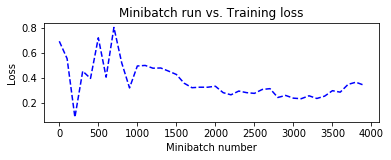

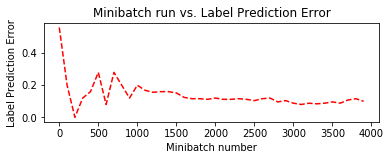

In [101]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the traingin loss and training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel("Minibatch number")
plt.ylabel("Loss")
plt.title("Minibatch run vs. Training loss")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel("Minibatch number")
plt.ylabel("Label Prediction Error")
plt.title("Minibatch run vs. Label Prediction Error")
plt.show()

# Evaluation / Testing

เอาหละเราก็ได้เทรนเน็ตเวิร์คของเราไปเป็นที่เรียบร้อยต่อไปเราจะมาทำการเทสกัน อันดับแรกเราต้องสร้างข้อมูลจำลองขึ้นมาใหม่เพื่อทดสอบและประเมินค่า average error และ loss ของข้อมูลชุดใหม่นี้ขั้นตอนที่ว่ามานี้สามารถทำได้โดยใช้ trainer.test_minibatch. ค่า error ที่ได้จากข้อมูลใหม่นี้จะนำไปเทียบกับค่า error ที่ได้จากข้อมูลชุด training. นี่คือหัวใจสำคัญของการเช็ค. ค่า error ควรมากกว่าจากที่ได้จากข้อมูลเทรนนิ่งมากมากมั้ย? ถ้ามากแสดงว่าโมเดลที่เราเทรนนั้นจะทำงานได้ไม่ดีในการเอาไปใช้งานจริง. ปัญหานี้เรียกว่า __[overfitting](https://en.wikipedia.org/wiki/Overfitting)__

เราจะทำการเทสกันโดยใช้แค่ 1 minibatch เพื่อให้เห็นภาพเท่านั้น. ในทางปฏิบัติจริงนั้นเราจะทดสอบด้วยการรันหลายๆ minibatch สำหรับ test data แล้วเก็บค่า average 

In [102]:
# Run the trained model on a newly generated dataset
test_minibatch_size = 25
features, labels = gen_random_data_sample(test_minibatch_size, input_dim, num_output_classes)
print(features)
print()
print(labels)

[[ 2.88554406  3.26451874]
 [ 1.97543406  1.1446389 ]
 [ 0.45586488  5.83427906]
 [ 5.8861413   9.27872562]
 [ 2.03527451  2.6846571 ]
 [ 2.18165493  2.1824429 ]
 [ 3.0994215   2.05849552]
 [ 3.27796865  5.01350355]
 [ 2.20912838  3.21114874]
 [ 3.33117819  2.81432199]
 [ 4.14156914  5.60748291]
 [ 9.32570553  7.34924555]
 [ 5.59477901  5.32280731]
 [ 5.42545986  3.40534949]
 [ 2.5545032   3.74071836]
 [ 3.16857696  2.04758596]
 [ 2.21663523  8.27714157]
 [ 2.59167624  2.42244864]
 [ 4.09626627  2.15165544]
 [ 9.55907917  5.20128441]
 [ 3.29597473  1.62561643]
 [ 8.31822014  7.25557327]
 [ 8.483181    3.69269753]
 [ 0.77930689  2.82612014]
 [ 3.9372952   2.88259029]]

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


In [103]:
trainer.test_minibatch({feature : features, label : labels})

0.08

## Checking prediction / evaluation

สำหรับการประเมินผลเราจะนำผลลัพธ์ที่ได้เข้าฟังก์ชั่น softmax เพื่อเปลี่ยนผลลัพธ์ให้เป็นการกระจายความน่าจะเป็นระหว่างสองคลาส(มะเร็ง vs. เนื้องอกธรรมดา)

In [104]:
out = C.softmax(z)
result = out.eval({feature: features})
print(result)

[[  9.90959883e-01   9.04012471e-03]
 [  9.99978304e-01   2.17025245e-05]
 [  9.59458411e-01   4.05416265e-02]
 [  1.98918656e-06   9.99997973e-01]
 [  9.99348104e-01   6.51910203e-04]
 [  9.99717891e-01   2.82132474e-04]
 [  9.99027610e-01   9.72444017e-04]
 [  5.74529529e-01   4.25470501e-01]
 [  9.97322381e-01   2.67769699e-03]
 [  9.92845356e-01   7.15461140e-03]
 [  8.39584321e-02   9.16041613e-01]
 [  4.45516719e-07   9.99999523e-01]
 [  1.53606497e-02   9.84639287e-01]
 [  5.57763696e-01   4.42236334e-01]
 [  9.85479534e-01   1.45204365e-02]
 [  9.98936117e-01   1.06384687e-03]
 [  6.93427585e-03   9.93065715e-01]
 [  9.99075890e-01   9.24078166e-04]
 [  9.93946612e-01   6.05339650e-03]
 [  3.05301655e-05   9.99969482e-01]
 [  9.99469697e-01   5.30268997e-04]
 [  2.83963686e-06   9.99997139e-01]
 [  4.51470306e-03   9.95485306e-01]
 [  9.99887228e-01   1.12801819e-04]
 [  9.77967143e-01   2.20328383e-02]]


In [105]:
print(type(result[0]))
print(len(result))

<class 'numpy.ndarray'>
25


In [106]:
print("Label :", [np.argmax(label) for label in labels])
num = len(result)
for i in range(num):
    print("Predicted " + str(i) + " :", [np.argmax(x) for x in result[i]])

Label : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Predicted 0 : [0, 0]
Predicted 1 : [0, 0]
Predicted 2 : [0, 0]
Predicted 3 : [0, 0]
Predicted 4 : [0, 0]
Predicted 5 : [0, 0]
Predicted 6 : [0, 0]
Predicted 7 : [0, 0]
Predicted 8 : [0, 0]
Predicted 9 : [0, 0]
Predicted 10 : [0, 0]
Predicted 11 : [0, 0]
Predicted 12 : [0, 0]
Predicted 13 : [0, 0]
Predicted 14 : [0, 0]
Predicted 15 : [0, 0]
Predicted 16 : [0, 0]
Predicted 17 : [0, 0]
Predicted 18 : [0, 0]
Predicted 19 : [0, 0]
Predicted 20 : [0, 0]
Predicted 21 : [0, 0]
Predicted 22 : [0, 0]
Predicted 23 : [0, 0]
Predicted 24 : [0, 0]


# Visualizaion

[ 8.21605396 -8.21605968]
[[-0.81946552  0.81943631]
 [-1.07306302  1.0730387 ]]


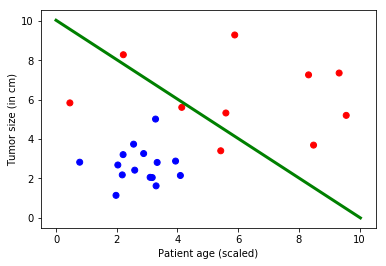

In [107]:
# Model parameters
print(mydict['b'].value)
print(mydict['w'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data 
import matplotlib.pyplot as plt

# let 0 represent malignant/red, and 1 represent benign/blue
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [108]:
print("Label :       ", [np.argmax(label) for label in labels])
print("Predicted : ", [np.argmax(row) for row in result])

Label :        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Predicted :  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]


In [109]:
count = 0
for i in range(len(labels)):
    if np.argmax(labels[i]) != np.argmax(result[i]):
        count += 1

print("Miss Count : " + str(count))

Miss Count : 2


In [110]:
percentage = (count / test_minibatch_size) * 100
print("Miss Percentage : " + str(percentage))

Miss Percentage : 8.0
